<div style="border: 10px solid blue; padding: 20px; font-family: Arial, sans-serif; text-align: center;">

# *RÉPUBLIQUE DU SÉNÉGAL*      
<div style="text-align: center;">
    <h3>Un peuple - un But - une Foi</h3>
</div>

<img src="Republique_du_Senegal.jpg" alt="Logo République du Sénégal" style="width: 100px; margin-top: 10px;">

---

## *Agence Nationale de la Statistique et de la Démographie*  
<img src="ANSD.jpg" alt="Logo ANSD" style="width: 120px; margin-top: 10px;">  

### *École Nationale de la Statistique et de l'Analyse Économique Pierre Ndiaye*  
<img src="ENSAE-Dakar-logo.jpg" alt="Logo ENSAE" style="width: 120px; margin-top: 10px;">

---

<div style="background-color: blue; color: white; text-align: center; padding: 10px; font-weight: bold; display: inline-block;">
Projet de Machine Learning 1
</div>

<div style="text-align: center;">
    <h3>Sujet :</h3>
</div>
    
    
---
    
## *Student Performance*  

---

<div style="text-align: center;">
    <h3>Rédigé par :</h3>
    <p style="font-size: 20px; text-align: center;">
        FAMARA SADIO<br>
        AMADOU YOUM<br>
        SARAN NDIAYE<br>
        YAGUE DIOP
    </p>
</div>

---

<div style="text-align: center;">
    <h3>Sous la supervision de :</h3>
    <p style="font-size: 20px; text-align: center;">
        MOUSLY DIAW<br>
        Data scientist / ML Engineer / Auto-Entrepreneur
    </p>
</div>
    
---

    © ISE2_Décembre 2024
    
</div>

## <b>PLAN</b>
## V. Modeling

### V.1. Training model 

### V.2. Model selection 

### V.3. Cross validation 

### V.4. Grid search

### V.5. Learning curves

### V.6. Residuals plot, Feature Importance, Prediction Error Plot, Recursive feat.Selection

### V.7. Prediction de la performance

# Importation des librairies

In [46]:
# Ignorer les avertissements
import warnings
warnings.filterwarnings('ignore')
import numpy as np   # pour les calculs scientifiques, algèbre, etc.
import pandas as pd  # manipuler les data frames 
import seaborn as sns #  pour faire les graphiques 
import matplotlib.pyplot as plt  # pour faire les graphiques 
import plotly.express as px # pour les graphes interactifs 
from ydata_profiling import ProfileReport # pour faire le rapport complet
from scipy.stats import chi2_contingency # affiche le tableau de contingence

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, GridSearchCV # decoupage en train et en test,validation croisée, courbe d'apprentissage  
from sklearn.pipeline import make_pipeline, Pipeline # pipieline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler # standardisation 
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error # metriques de validation 
from sklearn.impute import KNNImputer, SimpleImputer # pour imputer par les K plus proche voisins
from sklearn.pipeline import make_pipeline # pour le pipeline
from sklearn.compose import make_column_transformer # pour appliquer les transformers
from sklearn.compose import make_column_selector # pour sélectionner les types de variables


from sklearn.linear_model import LinearRegression, SGDRegressor # regression lineaire
from sklearn.linear_model import Ridge # Regression ridge 
from sklearn.linear_model import Lasso # Regression lasso 
from sklearn.linear_model import ElasticNet # Elastic net 
from sklearn.ensemble import RandomForestRegressor  # Pour le random forest
from sklearn.svm import SVR # Super vector Machine 
# Configuration des paramètres de scikit-learn
from sklearn import set_config
# Librairies pour l'évaluation des modèles et la manipulation des données
from sklearn import metrics
from sklearn.model_selection import cross_validate, cross_val_predict

from xgboost import XGBRegressor # Regression XGBoost
from sklearn.preprocessing import PolynomialFeatures   # polynomiales
from yellowbrick.target import FeatureCorrelation      # Pour le feature selection
from yellowbrick.model_selection import LearningCurve  # Courbes d'apprenstissages

# Importation de la base de données

In [56]:
data = pd.read_csv('StudentPerformanceFactors.csv')
target=data['Exam_Score']
features = data.drop(columns=['Exam_Score'])

# Rappel  des opérations à effectuer pour le pipeline

* Séparation du data set en varibales quantitatives et qualitatives
* Imputation des valeurs manquantes des variables catégorielles
* Correction des outliers de la variable cible du train 
* On a reservé la standardisation pour le pipeline 
* Encodage des variables catégorielles 

In [57]:
# Découpage des données en ensembles d'entraînement et de test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
# Vérification des longueurs
print("Taille de X_train :", len(X_train))
print("Taille de y_train :", len(y_train))

Taille de X_train : 5285
Taille de y_train : 5285


Dans la sélection des variables, nous n'avons pas traité les valeurs extrêmes
parce qu'elles vont être traiter dans le pipeline à travers le robustscaler, qui permet d'atténuer l'effet de valeurs extrêmes.

# Création du Pipeline

In [59]:
# Séparation des types de variables 
numerical_features = make_column_selector(dtype_include=np.number)
categorical_features = make_column_selector(dtype_exclude=np.number)

Le pipeline des variables quantitatives contient une technique d'imputation par la médiane et une transformation 
de ces variables par la technique de RobustScaler pour normaliser les données.

Pour une variable $x$, la transformation est donnée par :

$$x_{scaled} = \frac{x - Q_2}{Q_3 - Q_1}$$

où :

- $x$ : La valeur originale de la variable.
- $Q_1$: Le premier quartile (25e percentile).
- $Q_2$ : La médiane (50e percentile).
- $Q_3$ : Le troisième quartile (75e percentile).
- $Q_3 - Q_1$ : L'écart interquartile (**IQR**).


Pour le pipeline des variables qualitatives nous allons utiliser une technique d'imputation par le mode et une transformation des modalités de ces variables en de nouvelles variables dichotomiques à l'aide du one HoteEncoder


In [60]:
# Création des types de pipeline pour chaque type de variables
numerical_pipeline = make_pipeline(SimpleImputer(strategy='median'),
                                    RobustScaler())
categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'),
                                     OneHotEncoder())

In [61]:
# Transformer appliqué à chaque type de variables
preprocessing = make_column_transformer((numerical_pipeline, numerical_features),
                        (categorical_pipeline,categorical_features))
preprocessing

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001A3D53E5C10>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001A3D5F1BA90>)])

In [8]:
# Librairies 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor  # Assurez-vous d'avoir installé `xgboost


# Définition des modèles

| **Nom du modèle**              | **Formule mathématique**                                      | **Hyperparamètres**                                      |
|--------------------------------|-------------------------------------------------------------|--------------------------------------------------------|
| **Linear Regression**          | $y = \beta_0 + \beta_1 x_1 + \dots + \beta_n x_n + \epsilon$ | Aucun                                                  |
| **Ridge Regression**           | $\min ||y - X\beta||^2_2 + \alpha ||\beta||^2_2$             | alpha = 1.0                                            |
| **Lasso Regression**           | $\min ||y - X\beta||^2_2 + \alpha ||\beta||_1$               | alpha = 0.1                                            |
| **Elastic Net**                | $\min ||y - X\beta||^2_2 + \alpha (l_1 ||\beta||_1 + l_2 ||\beta||^2_2)$ | alpha = 0.1, l1_ratio = 0.5                            |
| **KNeighbors Regressor**       | $\hat{y} = \frac{1}{k} \sum_{i=1}^k y_i$                     | n_neighbors = 5                                        |
| **Random Forest Regressor**    | $\hat{y} = \frac{1}{M} \sum_{m=1}^M T_m(x)$                  | n_estimators = 100, random_state = 42                  |
| **Bagging Regressor**          | $\hat{y} = \frac{1}{M} \sum_{m=1}^M h_m(x)$                  | n_estimators = 10, random_state = 42                   |
| **Gradient Boosting Regressor**| $\hat{y} = \sum_{m=1}^M \gamma_m h_m(x)$                     | n_estimators = 100, random_state = 42                  |
| **xgBoost Regressor**          | $\hat{y} = \sum_{k=1}^K f_k(x), \, f_k \in \mathcal{F}$      | n_estimators = 100, random_state = 42                  |
| **SGD Regressor**              | $\min \frac{1}{2n} \sum_{i=1}^n (y_i - \beta^T x_i)^2 + \alpha ||\beta||_2^2$ | max_iter = 1000, tol = 1e-3, random_state = 42        |


In [9]:
# Définition des modèles
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Elastic Net": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "KNeighbors Regressor": KNeighborsRegressor(n_neighbors=5),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
    "Bagging Regressor": BaggingRegressor(n_estimators=10, random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "xgBoost Regressor": XGBRegressor(n_estimators=100, random_state=42),
    "SGD Regressor": SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
}


## Fonction pour l'entraînement et l'évaluation


In [10]:
# Fonction pour l'entraînement et l'évaluation

def train_model(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    error_train = np.mean((model.predict(x_train) - y_train) ** 2)
    error_test = np.mean((model.predict(x_test) - y_test) ** 2)
    print(f"Model error (test): {round(error_test, 5)}")
    return {"estimator": model, "error_train": error_train, "error_test": error_test}

## Métriques des validations du modèles

| **Nom de la métrique**                  | **Formule mathématique**                                       | **Interprétation**                                              |
|----------------------------------------|----------------------------------------------------------------|-----------------------------------------------------------------|
| **R² Score (Coefficient de détermination)** | $R^2 = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}$ | Indique la proportion de la variance expliquée par le modèle.  |
| **Mean Squared Error (MSE)**            | $\text{MSE} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2$     | Moyenne des carrés des erreurs. Pénalise davantage les grosses erreurs. |
| **Mean Absolute Percentage Error (MAPE)**| $\text{MAPE} = \frac{1}{n} \sum_{i=1}^n \left| \frac{y_i - \hat{y}_i}{y_i} \right| \times 100$ | Erreur moyenne absolue exprimée en pourcentage.                |
| **Max Error**                           | $\text{Max Error} = \max(|y_i - \hat{y}_i|)$                    | La plus grande différence absolue entre les valeurs réelles et prédites. |


## Fonction pour calculer les métriques sur train et test


In [11]:
# Fonction pour calculer les métriques sur train et test

def get_all_performances(values_train: tuple, values_test: tuple, metrics: list) -> pd.DataFrame:
    test_perfs = []
    train_perfs = []
    metric_names = []
    for metric_func in metrics:
        metric_name = metric_func.__name__
        metric_names.append(metric_name)
        train_perfs.append(metric_func(*values_train))
        test_perfs.append(metric_func(*values_test))
    perfs = {"metric": metric_names, "train": train_perfs, "test": test_perfs}
    return pd.DataFrame(perfs)

# Définition des métriques

METRICS = [
    metrics.r2_score,
    metrics.mean_squared_error,
    metrics.mean_absolute_percentage_error,
    metrics.max_error,
]

## Entraînement des modèles et présentation des résultats

In [26]:
# Entraînement des modèles et présentation des résultats
import warnings
warnings.filterwarnings('ignore')
results = {}
for name, model in models.items():
    pipeline = make_pipeline(preprocessing, model)
    model_results = train_model(pipeline, X_train, y_train, X_test, y_test)
    values_train = (y_train, pipeline.predict(X_train))
    values_test = (y_test, pipeline.predict(X_test))
    perf_df = get_all_performances(values_train, values_test, METRICS)
    results[name] = perf_df

Model error (test): 3.25604
Model error (test): 3.25592
Model error (test): 3.99145
Model error (test): 3.79635
Model error (test): 7.6489
Model error (test): 4.68912
Model error (test): 5.22207
Model error (test): 3.7699
Model error (test): 4.633
Model error (test): 3.27834


##  Affichage des résultats sous forme de tableau 

In [13]:
# Affichage des résultats sous forme de tableau 

for model_name, perf_df in results.items():
    print(f"\nPerformance Metrics for {model_name}\n")
    print(perf_df)


Performance Metrics for Linear Regression

                           metric      train       test
0                        r2_score   0.717314   0.769648
1              mean_squared_error   4.347986   3.256044
2  mean_absolute_percentage_error   0.006782   0.006286
3                       max_error  29.953613  28.012451

Performance Metrics for Ridge Regression

                           metric      train       test
0                        r2_score   0.717314   0.769657
1              mean_squared_error   4.347989   3.255918
2  mean_absolute_percentage_error   0.006782   0.006286
3                       max_error  29.953768  28.006976

Performance Metrics for Lasso Regression

                           metric      train       test
0                        r2_score   0.658832   0.717621
1              mean_squared_error   5.247494   3.991454
2  mean_absolute_percentage_error   0.014059   0.013145
3                       max_error  30.429969  27.143737

Performance Metrics for Elast

## Affichage des métriques sous forme graphique

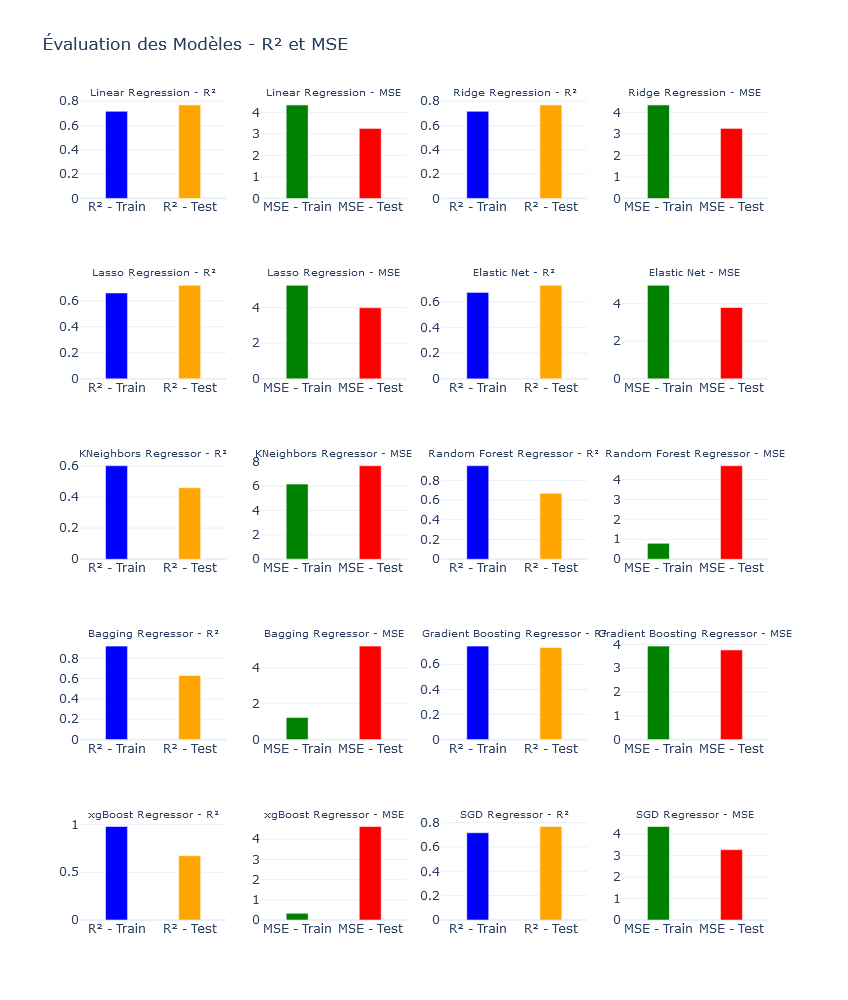

In [14]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Fonction pour tracer des graphiques R² et MSE en barres pour Train et Test
def plot_metric_bars_separated(fig, row, col, metric_df, metric_name, model_name, y_label, colors):
    # graphe du jeu d'entraînement
    fig.add_trace(go.Bar(
        x=[f"{metric_name} - Train"],
        y=[metric_df["train"].values[0]],
        name="Train",
        marker_color=colors["train"],
        width=0.3
    ), row=row, col=col)

    # graphe du jeu de test
    fig.add_trace(go.Bar(
        x=[f"{metric_name} - Test"],
        y=[metric_df["test"].values[0]],
        name="Test",
        marker_color=colors["test"],
        width=0.3
    ), row=row, col=col)

# Affichage des graphes (5 lignes et 4 colonnes)
fig = make_subplots(
    rows=5,
    cols=4,
    subplot_titles=[f"{model_name} - {metric}" 
                    for model_name in results.keys() 
                    for metric in ["R²", "MSE"]]
)

# initialisation
row, col = 1, 1

# Visualisation pour chaque modèle
for model_name, perf_df in results.items():
    # Graphique pour R²
    r2_df = perf_df[perf_df["metric"] == "r2_score"]
    plot_metric_bars_separated(
        fig=fig,
        row=row,
        col=col,
        metric_df=r2_df,
        metric_name="R²",
        model_name=model_name,
        y_label="R² Score",
        colors={"train": "blue", "test": "orange"}
    )

    # Avancer la colonne
    col += 1
    if col > 4:
        col = 1
        row += 1

    # Graphique pour MSE
    mse_df = perf_df[perf_df["metric"] == "mean_squared_error"]
    plot_metric_bars_separated(
        fig=fig,
        row=row,
        col=col,
        metric_df=mse_df,
        metric_name="MSE",
        model_name=model_name,
        y_label="MSE",
        colors={"train": "green", "test": "red"}
    )

    # Avancer la colonne
    col += 1
    if col > 4:
        col = 1
        row += 1

# Mise en page finale des graphiques
fig.update_layout(
    title_text="Évaluation des Modèles - R² et MSE",
    height=1000,  # Ajuste la hauteur totale pour 5 lignes
    width=900,   # Ajuste la largeur pour 4 colonnes
    showlegend=False,  # Supprime la légende
    template="plotly_white"
)

# Réduction de la taille des sous-titres
fig.update_annotations(font_size=10)

# Affichage
fig.show()


##  Sélection du meilleur modèle selon $R^2$ et MSE
- Le meilleur modèle est celui qui a un $R^2$ élevé et un MSE faible

In [15]:
# Sélection du meilleur modèle selon R^2 et MSE
best_r2 = max(results.items(), key=lambda x: x[1].loc[x[1]["metric"] == "r2_score", "test"].values[0])
best_mse = min(results.items(), key=lambda x: x[1].loc[x[1]["metric"] == "mean_squared_error", "test"].values[0])

print(f"Best model by R^2: {best_r2[0]} with R^2 = {best_r2[1].loc[best_r2[1]['metric'] == 'r2_score', 'test'].values[0]}")
print(f"Best model by MSE: {best_mse[0]} with MSE = {best_mse[1].loc[best_mse[1]['metric'] == 'mean_squared_error', 'test'].values[0]}")

Best model by R^2: Ridge Regression with R^2 = 0.7696567569680504
Best model by MSE: Ridge Regression with MSE = 3.2559184339353076


- Le meilleur modèle est le modèle Ridge selon les valeurs de MSE et R²

- MSE=3.2559184339353076,  et R²= 0.7696567569680504

<div style="background-color: RGB(51,165,182); text-align: left;">
    <h1 style="margin: auto; padding: 20px; color:#fff;"><b> V.3. Cross Validation</b></h1>
</div>

### Principe

1. **Division des données**  
   Le jeu de données est divisé en $k$ parties égales. Par exemple, avec $k = 5$, les données sont divisées ainsi :

   | Partie | D1      | D2      | D3      | D4      | D5      |
   |--------|---------|---------|---------|---------|---------|

2. **Entraînement et test (itérations)**  
   À chaque itération, une partie est utilisée pour tester le modèle, et les autres pour l'entraînement :

   | Itération | Jeu d'entraînement              | Jeu de test |
   |-----------|----------------------------------|-------------|
   | 1         | D2, D3, D4, D5                  | D1          |
   | 2         | D1, D3, D4, D5                  | D2          |
   | 3         | D1, D2, D4, D5                  | D3          |
   | 4         | D1, D2, D3, D5                  | D4          |
   | 5         | D1, D2, D3, D4                  | D5          |

3. **Calcul des scores $R^2$**  
   Après chaque itération, on mesure le score $R^2$ du modèle sur le jeu de test (par exemple, $R^2_1, R^2_2, R^2_3, R^2_4, R^2_5$).

4. **Moyenne des scores $R^2$**  
   La performance finale du modèle est mesurée par la moyenne des scores $R^2$ obtenus sur les $k$ itérations :

   | Itération | $R^2$ Score |
   |-----------|---------------|
   | 1         | $R^2_1$     |
   | 2         | $R^2_2$     |
   | 3         | $R^2_3$     |
   | 4         | $R^2_4$     |
   | 5         | $R^2_5$     |

   La moyenne des scores $R^2$ est calculée comme suit :
   $$R^2_{\text{cv}} = \frac{1}{k} \sum_{i=1}^{k} R^2_i$$
   
   
Nous allons appliquer la technique de validation croisée à tous les modèles pour sélectionner le meilleur.
Les métriques de validation sont R^2 et MSE

In [16]:
from sklearn.model_selection import cross_val_score, KFold

# Fonction pour effectuer une validation croisée et calculer les métriques
def cross_validate_model(model, X, y, cv_folds=5, scoring='neg_mean_squared_error'):
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X, y, cv=kf, scoring=scoring)
    mean_score = np.mean(cv_scores)
    std_score = np.std(cv_scores)
    return mean_score, std_score

# Entraînement et validation croisée pour tous les modèles
cv_results = {}
for name, model in models.items():
    pipeline = make_pipeline(preprocessing, model)
    
    # Validation croisée
    mse_mean, mse_std = cross_validate_model(pipeline, X_train, y_train, cv_folds=5, scoring='neg_mean_squared_error')
    r2_mean, r2_std = cross_validate_model(pipeline, X_train, y_train, cv_folds=5, scoring='r2')
    
    # Stockage des résultats
    cv_results[name] = {
        "MSE Mean": -mse_mean,  # On change le signe car MSE est retourné négatif
        "MSE Std": mse_std,
        "R² Mean": r2_mean,
        "R² Std": r2_std
    }

# Affichage des résultats de validation croisée
cv_results_df = pd.DataFrame(cv_results).T  # Transpose pour une meilleure lisibilité
print(cv_results_df)

# Sélection du meilleur modèle selon la moyenne des R² et MSE
best_r2_model = cv_results_df["R² Mean"].idxmax()
best_mse_model = cv_results_df["MSE Mean"].idxmin()

print(f"Best model by R²: {best_r2_model} with R² Mean = {cv_results_df.loc[best_r2_model, 'R² Mean']:.4f}")
print(f"Best model by MSE: {best_mse_model} with MSE Mean = {cv_results_df.loc[best_mse_model, 'MSE Mean']:.4f}")

                             MSE Mean   MSE Std   R² Mean    R² Std
Linear Regression            4.401317  0.758464  0.715503  0.034148
Ridge Regression             4.400138  0.759833  0.715588  0.034230
Lasso Regression             5.290746  0.781476  0.657620  0.031627
Elastic Net                  5.024878  0.778910  0.674994  0.032251
KNeighbors Regressor         9.212776  0.770635  0.401511  0.016753
Random Forest Regressor      5.945190  0.837027  0.614977  0.034036
Bagging Regressor            6.666605  0.902787  0.568177  0.035447
Gradient Boosting Regressor  5.014745  0.800496  0.675672  0.034296
xgBoost Regressor            5.844528  0.770487  0.621245  0.032622
SGD Regressor                4.408514  0.764262  0.715058  0.034575
Best model by R²: Ridge Regression with R² Mean = 0.7156
Best model by MSE: Ridge Regression with MSE Mean = 4.4001


<div style="background-color: RGB(51,165,182); text-align: left;">
    <h1 style="margin: auto; padding: 20px; color:#fff;"><b> V.4.Grid Search </b></h1>
</div>

Le **Grid Search** est une méthode d'optimisation des hyperparamètres en machine learning. Son principe est de **tester toutes les combinaisons possibles d'hyperparamètres** d'un modèle pour trouver celle qui optimise une métrique de performance donnée par exemple le $R^2$.

Voici un résumé en étapes :

1. **Définir l'ensemble des hyperparamètres** : Choisir un ensemble d'hyperparamètres à tester, avec plusieurs valeurs possibles pour chaque hyperparamètre.
   
2. **Créer une grille de recherche** : Combiner toutes les valeurs possibles des hyperparamètres en une grille.
   
3. **Entraînement et évaluation** : Pour chaque combinaison d'hyperparamètres dans la grille, entraîner le modèle et évaluer sa performance sur un ensemble de validation.

4. **Sélection du meilleur modèle** : Choisir la combinaison d'hyperparamètres qui donne les meilleures performances sur l'ensemble de validation.

In [17]:
from sklearn.model_selection import GridSearchCV

# Grilles d'hyperparamètres pour différents modèles
param_grids = {
    "Ridge Regression": {"ridge__alpha": [0.01, 0.1, 1.0, 10.0, 100.0]},
    "Lasso Regression": {"lasso__alpha": [0.01, 0.1, 1.0, 10.0]},
    "Elastic Net": {"elasticnet_alpha": [0.01, 0.1, 1.0], "elasticnet_l1_ratio": [0.1, 0.5, 0.9]},
    "KNeighbors Regressor": {"kneighborsregressor__n_neighbors": [3, 5, 7, 9]},
    "Random Forest Regressor": {"randomforestregressor__n_estimators": [50, 100, 200], 
                                "randomforestregressor__max_depth": [None, 10, 20]},
    "Gradient Boosting Regressor": {"gradientboostingregressor__n_estimators": [50, 100, 200], 
                                    "gradientboostingregressor__learning_rate": [0.01, 0.1, 0.2]},
    "xgBoost Regressor": {"xgbregressor__n_estimators": [50, 100, 200], 
                          "xgbregressor__learning_rate": [0.01, 0.1, 0.2]},
    "SGD Regressor": {"sgdregressor__alpha": [0.0001, 0.001, 0.01], 
                      "sgdregressor__penalty": ["l2", "l1", "elasticnet"]}
}

# Récupérer le meilleur modèle selon R² (ou MSE)
selected_model_name = best_r2_model  # Change en best_mse_model si nécessaire
print(f"Selected model for hyperparameter optimization: {selected_model_name}")

# Vérifier si une grille existe pour le modèle sélectionné
if selected_model_name in param_grids:
    # Définir le pipeline pour GridSearchCV
    pipeline = make_pipeline(preprocessing, models[selected_model_name])
    param_grid = param_grids[selected_model_name]
    
    # Configurer GridSearchCV
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='r2',  # Utiliser R² comme métrique pour l'optimisation
        cv=5,  # Validation croisée 5-fold
        n_jobs=-1,  # Utiliser tous les cœurs disponibles
        verbose=2  # Afficher les informations détaillées
    )
    
    # Lancer l'optimisation
    grid_search.fit(X_train, y_train)
    
    # Afficher les meilleurs paramètres et le score
    print(f"Best parameters for {selected_model_name}: {grid_search.best_params_}")
    print(f"Best R² score during Grid Search: {grid_search.best_score_:.4f}")
else:
    print(f"No hyperparameter grid defined for {selected_model_name}.")

Selected model for hyperparameter optimization: Ridge Regression
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters for Ridge Regression: {'ridge__alpha': 10.0}
Best R² score during Grid Search: 0.7232


## Comparaison valeurs observées et valeurs prédites

In [18]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np

# Fonction pour effectuer une validation croisée et calculer les métriques
def cross_validate_model(model, X, y, cv_folds=5, scoring='r2'):
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X, y, cv=kf, scoring=scoring)
    mean_score = np.mean(cv_scores)
    std_score = np.std(cv_scores)
    return mean_score, std_score

# Entraînement et validation croisée pour tous les modèles
cv_results = {}
for name, model in models.items():
    pipeline = make_pipeline(preprocessing, model)
    
    # Validation croisée
    mse_mean, mse_std = cross_validate_model(pipeline, X_train, y_train, cv_folds=5, scoring='r2')
    r2_mean, r2_std = cross_validate_model(pipeline, X_train, y_train, cv_folds=5, scoring='r2')
    
    # Stockage des résultats
    cv_results[name] = {
        "MSE Mean": -mse_mean,  # On change le signe car MSE est retourné négatif
        "MSE Std": mse_std,
        "R² Mean": r2_mean,
        "R² Std": r2_std
    }

# Affichage des résultats de validation croisée
cv_results_df = pd.DataFrame(cv_results).T  # Transpose pour une meilleure lisibilité
# print(cv_results_df)

# Sélection du meilleur modèle selon la moyenne des R² et MSE
best_r2_model = cv_results_df["R² Mean"].idxmax()
best_mse_model = cv_results_df["MSE Mean"].idxmin()

# print(f"Best model by R²: {best_r2_model} with R² Mean = {cv_results_df.loc[best_r2_model, 'R² Mean']:.4f}")
# print(f"Best model by MSE: {best_mse_model} with MSE Mean = {cv_results_df.loc[best_mse_model, 'MSE Mean']:.4f}")

# Sélection du meilleur modèle en fonction du R² ou MSE, ici le meilleur modèle selon le R²
best_model_name = best_r2_model  # Ou utilisez best_mse_model pour le meilleur modèle basé sur MSE
best_model = models[best_model_name]  # On récupère l'objet modèle réel

# Création du pipeline avec le meilleur modèle
best_pipeline = make_pipeline(preprocessing, best_model)

# Entraînement du meilleur modèle sur l'ensemble d'entraînement
#best_pipeline.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = best_pipeline.predict(X_test)

# Créer un tableau comparant y_test et y_pred
comparison_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred
})


# Afficher le tableau de comparaison
print(comparison_df.head())  # Affichez les premières lignes pour un aperçua

      y_test     y_pred
743       65  64.527497
5551      65  65.266712
3442      71  71.528173
6571      64  64.279142
4204      66  66.521903


<div style="background-color: RGB(51,165,182); text-align: left;">
    <h1 style="margin: auto; padding: 20px; color:#fff;"><b> V.5. Learning Curves </b></h1>
</div>

Les **courbes d'apprentissage** sont utilisés en machine learning pour visualiser l'évolution de la performance d'un modèle à mesure qu'il apprend.

Elles permettent de suivre l'évolution de deux métriques pendant l'entraînement : l'erreur sur le jeu d'entraînement et l'erreur sur le jeu de validation.

### Principaux types de courbes d'apprentissage :
1. **Erreur d'entraînement** : Représente l'évolution de l'erreur (ou de la performance) sur l'ensemble d'entraînement à chaque itération ou à chaque époque.
2. **Erreur de validation** : Représente l'évolution de l'erreur (ou de la performance) sur l'ensemble de validation au fur et à mesure de l'entraînement.

### Interprétation des courbes d'apprentissage :
- **Sous-apprentissage** : Lorsque l'erreur d'entraînement est élevée et que l'erreur de validation est également élevée, cela indique que le modèle n'a pas appris correctement.
- **Sur-apprentissage** (Overfitting) : Lorsque l'erreur d'entraînement est faible, mais que l'erreur de validation est élevée, cela suggère que le modèle a mémorisé les données d'entraînement mais ne généralise pas bien aux nouvelles données.
- **Apprentissage optimal** : Lorsque les erreurs d'entraînement et de validation diminuent de manière similaire, cela indique que le modèle apprend correctement et généralise bien.

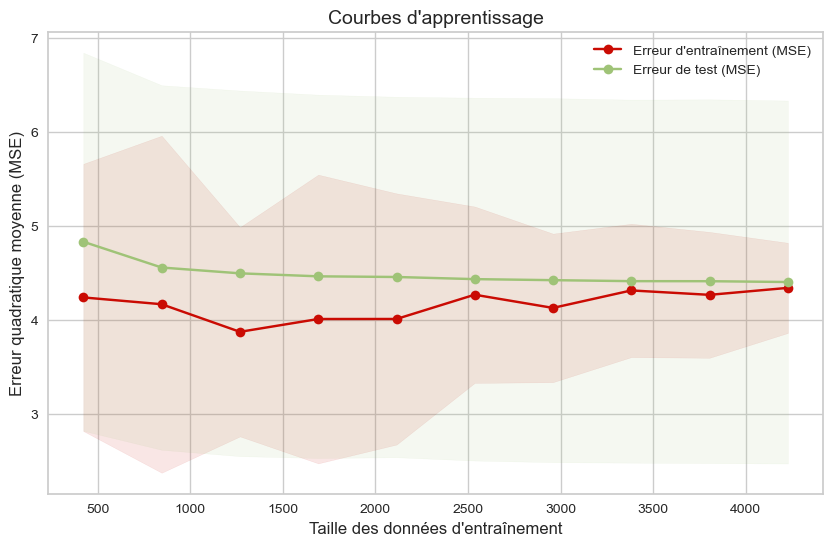

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve_with_confidence(model, X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)):
    """
    Trace les courbes d'apprentissage avec intervalles de confiance.
    
    Arguments :
    - model : le modèle ou pipeline scikit-learn à évaluer
    - X : les données d'entraînement (features)
    - y : les cibles (target)
    - cv : nombre de folds pour la validation croisée (par défaut 5)
    - scoring : métrique utilisée pour évaluer le modèle (par défaut 'neg_mean_squared_error')
    - train_sizes : fractions des données d'entraînement utilisées pour tracer les courbes
    """
    # Calcul des scores d'apprentissage et de validation
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, train_sizes=train_sizes, cv=cv, scoring=scoring, n_jobs=-1, shuffle=True, random_state=42
    )
    
    # Moyennes et écarts-types des scores
    train_scores_mean = -np.mean(train_scores, axis=1)  # On change le signe car MSE est négatif
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)  # Idem pour les scores de validation
    test_scores_std = np.std(test_scores, axis=1)
    
    # Tracer les courbes
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Erreur d'entraînement (MSE)")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Erreur de test (MSE)")

    # Ajouter les intervalles de confiance
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                     alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                     alpha=0.1, color="g")
    
    # Titrage et légendes
    plt.title("Courbes d'apprentissage", fontsize=14)
    plt.xlabel("Taille des données d'entraînement", fontsize=12)
    plt.ylabel("Erreur quadratique moyenne (MSE)", fontsize=12)
    plt.legend(loc="best", fontsize=10)
    plt.grid(True)
    plt.show()

# Exemple d'utilisation
# pipeline = make_pipeline(preprocessing, models[best_r2_model])  # Modèle sélectionné
pipeline = make_pipeline(preprocessing, models[best_r2_model])  # Remplacer par le modèle souhaité
plot_learning_curve_with_confidence(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

On constate que les erreurs d'entraînement et de validation sont différents, mais qui tendent à diminuer de manière similaire, cela indique que le modèle apprend correctement et généralise bien.

<div style="background-color: RGB(51,165,182); text-align: left;">
    <h1 style="margin: auto; padding: 20px; color:#fff;"><b> V.6. Residuals Plot, Feature Importance, Prediction Error Plot, Recursive Feat. Selection  </b></h1>
</div>

# Residuals Plot

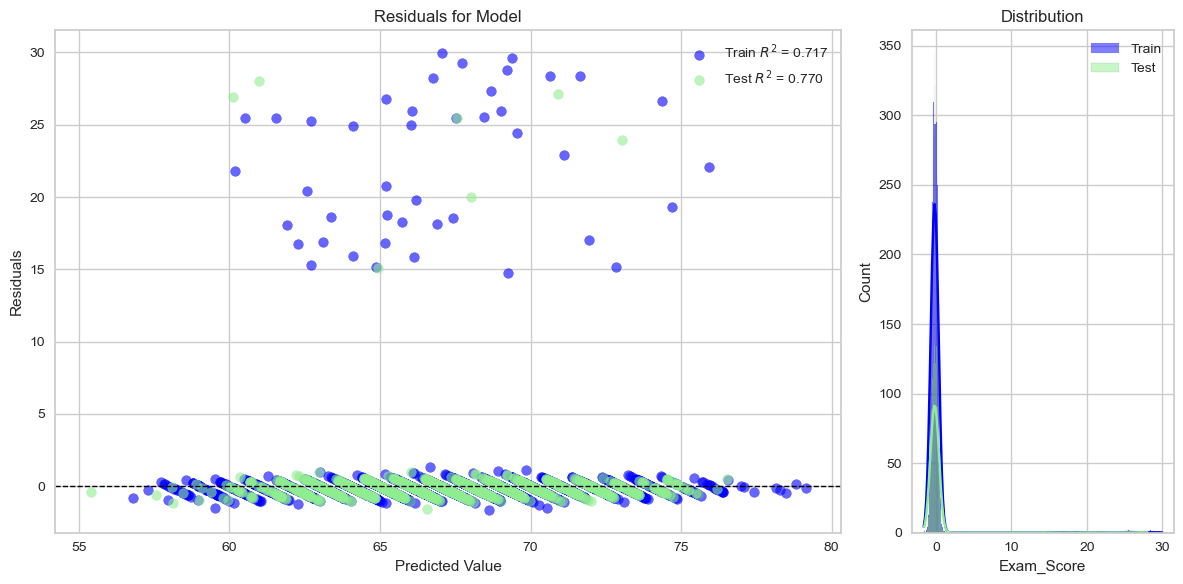

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_residuals_with_distribution(model, X_train, y_train, X_test, y_test):
    """
    Trace les résidus vs valeurs ajustées avec une distribution des résidus pour les ensembles d'entraînement et de test.
    
    Arguments :
    - model : modèle scikit-learn entraîné
    - X_train, y_train : données d'entraînement
    - X_test, y_test : données de test
    """
    # Prédictions pour l'entraînement et le test
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calcul des résidus
    residuals_train = y_train - y_train_pred
    residuals_test = y_test - y_test_pred
    
    # R² pour l'entraînement et le test
    r2_train = model.score(X_train, y_train)
    r2_test = model.score(X_test, y_test)
    
    # Création de la figure
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={"width_ratios": [3, 1]})
    
    # Scatter plot des résidus
    ax[0].scatter(y_train_pred, residuals_train, color="blue", alpha=0.6, label=f"Train $R^2$ = {r2_train:.3f}")
    ax[0].scatter(y_test_pred, residuals_test, color="lightgreen", alpha=0.6, label=f"Test $R^2$ = {r2_test:.3f}")
    ax[0].axhline(y=0, color="black", linestyle="--", linewidth=1)
    ax[0].set_title("Residuals for Model")
    ax[0].set_xlabel("Predicted Value")
    ax[0].set_ylabel("Residuals")
    ax[0].legend(loc="best")
    ax[0].grid(True)
    
    # Distribution des résidus
    sns.histplot(residuals_train, kde=True, color="blue", alpha=0.5, label="Train", ax=ax[1], orientation="horizontal")
    sns.histplot(residuals_test, kde=True, color="lightgreen", alpha=0.5, label="Test", ax=ax[1], orientation="horizontal")
    ax[1].axhline(y=0, color="black", linestyle="--", linewidth=1)
    ax[1].set_title("Distribution")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    
    # Ajustement des espaces entre les sous-graphiques
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation
# pipeline est le meilleur modèle entraîné
pipeline.fit(X_train, y_train)
plot_residuals_with_distribution(pipeline, X_train, y_train, X_test, y_test)

# Feature Importance

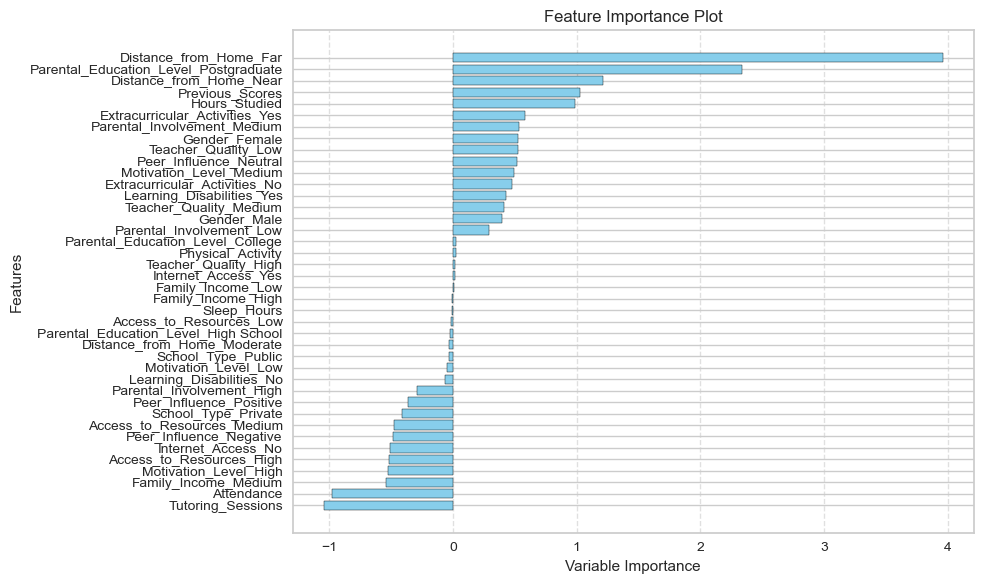

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge

def plot_feature_importance(feature_importances, feature_names):
    """
    Trace un graphique de l'importance des variables.

    Arguments :
    - feature_importances : liste ou tableau des importances des caractéristiques
    - feature_names : liste des noms des caractéristiques
    """
    # Convertir en DataFrame pour un tri facile
    feature_data = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })
    # Trier les caractéristiques par importance décroissante
    feature_data = feature_data.sort_values(by='Importance', ascending=True)
    
    # Création du graphique
    plt.figure(figsize=(10, 6))
    plt.barh(feature_data['Feature'], feature_data['Importance'], color='skyblue', edgecolor='black')
    plt.xlabel("Variable Importance")
    plt.ylabel("Features")
    plt.title("Feature Importance Plot")
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation avec un modèle de régression Ridge

# Supposons que X_train soit un DataFrame et y_train la variable cible
# Vous devez adapter ces variables à votre jeu de données réel
# X_train = ...
# y_train = ...

# Identifier les colonnes catégorielles et numériques
categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(exclude=['object']).columns

# Créer un préprocesseur pour transformer les variables catégorielles avec OneHotEncoder et les numériques avec RobustScaler
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols),
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', RobustScaler())  # Ajout du RobustScaler pour les variables numériques
        ]), numerical_cols)
    ]
)

# Créer un pipeline avec prétraitement et modèle Ridge avec alpha=10
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=10))  # Utilisation du modèle Ridge avec alpha=10
])

# Diviser les données en un ensemble d'entraînement et un ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Entraînement du modèle
pipeline.fit(X_train, y_train)

# Récupération des importances et des noms des variables
importances = pipeline.named_steps['regressor'].coef_  # Utilisation des coefficients pour Ridge
# Les noms des variables après transformation par OneHotEncoder
encoded_feature_names = pipeline.named_steps['preprocessor'].transformers_[0][1].named_steps['encoder'].get_feature_names_out(categorical_cols)
all_feature_names = list(numerical_cols) + list(encoded_feature_names)

# Tracer le graphique
plot_feature_importance(importances, all_feature_names)

## Interprétation 

- Ce graphique présente l'importance relative des variables dans le modèle de régression Ridge.
 
- Les variables avec les barres les plus longues, vers la droite, ont un impact significatif et positif sur le modèle:
`Distance_from_Home_Far`  
 `Parental_Education_Level_Postgraduate`  
 `Distance_from_Home_Near` 
Cela signifie que ces variables influencent fortement la variable cible **exam_score**.

 
 Les variables avec des valeurs négatives, vers la gauche, influencent **négativement** le modèle:
 `Motivation_Level_High`  
 `Family_Income_Medium`  
 `Attendance`  
Par exemple, un haut niveau de motivation est associé à une baisse des scores.
  
- Les variables situées près de zéro (avec des barres très courtes) n'ont presque pas d'impact sur la  prédiction. Elles pourraient être analysées plus en profondeur pour comprendre leur faible contribution.

# Prediction Error Plot

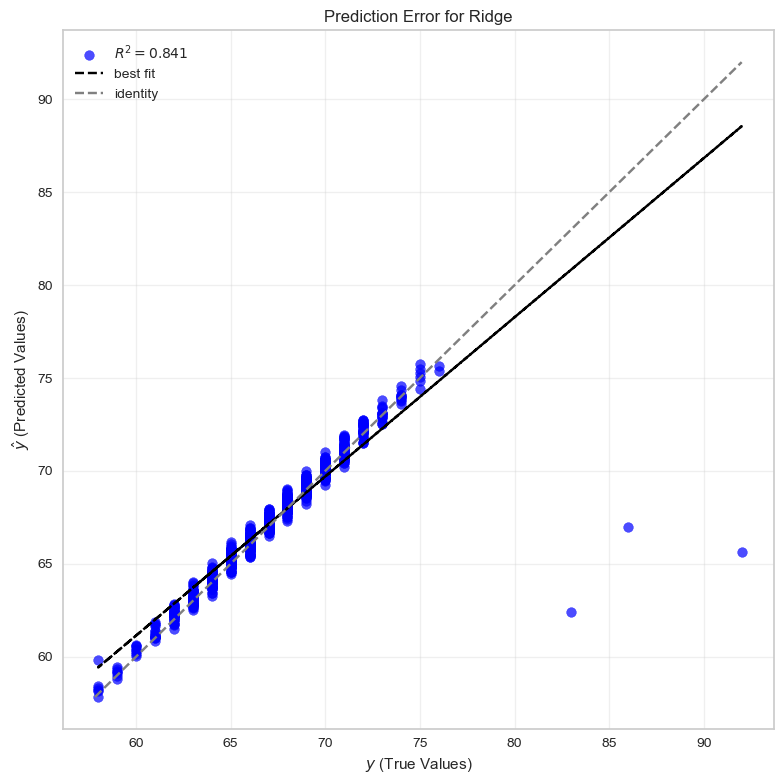

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

def plot_prediction_error(y_true, y_pred, model_name="Model"):
    """
    Trace un graphique d'erreur de prédiction avec les valeurs prédites et réelles.

    Arguments :
    - y_true : les valeurs réelles
    - y_pred : les valeurs prédites
    - model_name : nom du modèle
    """
    # Calculer le R²
    r2 = r2_score(y_true, y_pred)
    
    # Création du graphique
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, label=f"$R^2 = {r2:.3f}$", alpha=0.7, color='blue')
    
    # Ajuster une droite aux données
    fit = np.polyfit(y_true, y_pred, 1)
    fit_fn = np.poly1d(fit)
    plt.plot(y_true, fit_fn(y_true), linestyle='--', color='black', label='best fit')
    
    # Tracer la ligne d'identité
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray', label='identity')
    
    # Configuration du graphique
    plt.xlabel('$y$ (True Values)')
    plt.ylabel('$\hat{y}$ (Predicted Values)')
    plt.title(f"Prediction Error for {model_name}")
    plt.legend(loc="upper left")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Supposons que X_train, X_test, y_train, y_test aient déjà été définis

# Créer et entraîner le modèle Ridge avec alpha=10
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Identifier les colonnes catégorielles et numériques
categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(exclude=['object']).columns

# Créer un préprocesseur pour transformer les variables catégorielles avec OneHotEncoder et les numériques avec RobustScaler
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols),
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', RobustScaler())  # Ajout du RobustScaler pour les variables numériques
        ]), numerical_cols)
    ]
)

# Créer un pipeline avec prétraitement et modèle Ridge avec alpha=10
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=10))  # Utilisation du modèle Ridge avec alpha=10
])

# Diviser les données en un ensemble d'entraînement et un ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Entraînement du modèle
pipeline.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = pipeline.predict(X_test)

# Tracer le graphique d'erreur de prédiction
plot_prediction_error(y_test, y_pred, model_name="Ridge")

## Interprétation du graphique d'erreur de prédiction

Ce graphique compare les **valeurs réelles** $y$  et les **valeurs prédites** $\hat{y}$ obtenues avec le modèle de régression Ridge.

### 1. **Ligne d'identité (grise)**  
- Cette ligne représente la situation idéale où les valeurs prédites $\hat{y}$ sont parfaitement égales aux valeurs réelles  $y$  :

$\hat{y}= y$

- Plus les points sont proches de cette ligne, plus les prédictions sont précises.

### 2. **Ligne de régression ajustée (noire en pointillés)**  
- Elle montre la tendance globale des prédictions par rapport aux valeurs réelles.  

### 4. **Coefficient $R^2$** 

Le coefficient $R^2$ mesure la qualité d'ajustement du modèle aux données :

$R^2 = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}$

où :  
- \$y_i$ sont les valeurs réelles, 

- $\hat{y}_i\$ sont les valeurs prédites, 

- $\bar{y}\$ est la moyenne des valeurs réelles.  

Ici, $R^2$ = 0.841, ce qui signifie que le modèle explique en grande partie la variance des données.

# Recursive Feat. Selection

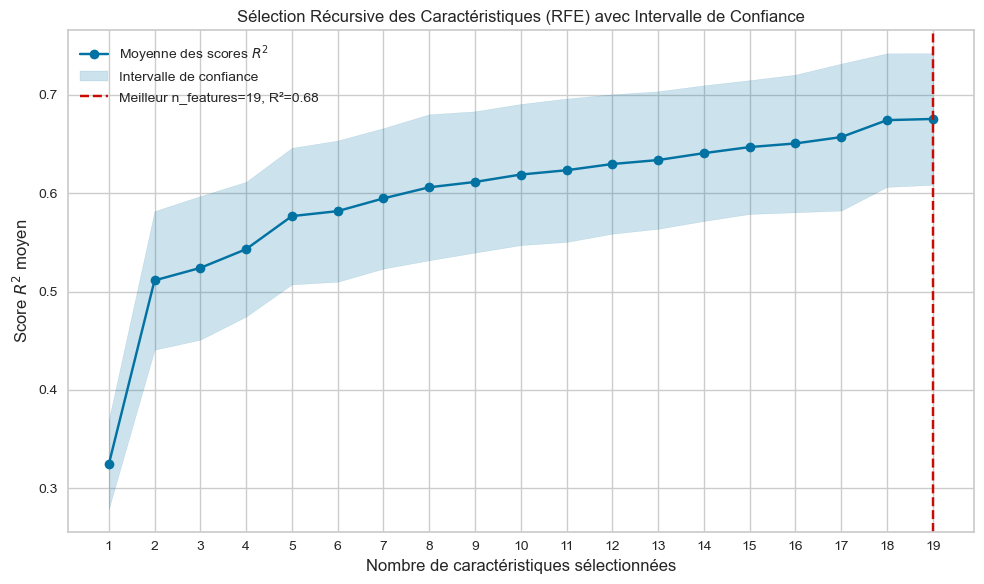

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
from sklearn.feature_selection import RFE
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Exemple de données d'entraînement (X_train et y_train) - à adapter à votre cas
# X_train = ...
# y_train = ...

# Modèle Ridge avec alpha=10
best_model = Ridge(alpha=10)

# Fonction pour effectuer la validation croisée et calculer les scores R²
def cross_validate_model(model, X, y, cv_folds=5, scoring='r2'):
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf, scoring=scoring)
    return np.mean(scores), np.std(scores)

# Identifier les colonnes catégorielles et numériques
categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(exclude=['object']).columns

# Créer un préprocesseur pour transformer les variables catégorielles avec OneHotEncoder et les numériques avec StandardScaler
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore')), categorical_cols),
        ('num', make_pipeline(SimpleImputer(strategy='mean'), RobustScaler()), numerical_cols)
    ]
)

# Initialiser le RFE avec le modèle choisi
num_features = X_train.shape[1]
mean_scores = []
std_scores = []

# Effectuer la sélection récursive des caractéristiques et calculer les scores R² avec validation croisée
best_n_features = None
best_r2_score = None

for n_features in range(1, num_features + 1):
    rfe = RFE(estimator=best_model, n_features_to_select=n_features)
    
    # Pipeline complet avec préprocesseur, RFE et le modèle Ridge
    pipeline = make_pipeline(preprocessor, rfe, best_model)
    
    # Validation croisée avec les caractéristiques sélectionnées
    r2_mean, r2_std = cross_validate_model(pipeline, X_train, y_train, cv_folds=5, scoring='r2')
    
    # Enregistrement des scores moyens et de l'écart-type
    mean_scores.append(r2_mean)
    std_scores.append(r2_std)
    
    # Stocker les meilleurs résultats
    if best_r2_score is None or r2_mean > best_r2_score:
        best_n_features = n_features
        best_r2_score = r2_mean

# Tracer les résultats
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_features + 1), mean_scores, 'o-', color="b", label="Moyenne des scores $R^2$")
plt.fill_between(range(1, num_features + 1),
                 np.array(mean_scores) - np.array(std_scores),
                 np.array(mean_scores) + np.array(std_scores),
                 color="b", alpha=0.2, label="Intervalle de confiance")

# Tracer la ligne verticale indiquant le meilleur nombre de features sélectionnées
plt.axvline(x=best_n_features, color='r', linestyle='--', label=f"Meilleur n_features={best_n_features}, R²={best_r2_score:.2f}")

# Titrage et légendes
plt.title("Sélection Récursive des Caractéristiques (RFE) avec Intervalle de Confiance")
plt.xlabel("Nombre de caractéristiques sélectionnées", fontsize=12)
plt.ylabel("Score $R^2$ moyen", fontsize=12)
plt.xticks(range(1, num_features + 1))
plt.legend(loc="best", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

<div style="background-color: RGB(51,165,182); text-align: left;">
    <h1 style="margin: auto; padding: 20px; color:#fff;"><b> V.7. Prediction de la Performance  </b></h1>
</div>

In [24]:
# Séparation des variables explicatives (X) et de la variable cible (y)
X = data.drop(columns='Exam_Score')
y = data['Exam_Score']
# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Définir un préprocesseur pour les variables catégorielles
categorical_features = X.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputation des valeurs manquantes
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # Encodage OneHot
])
# Définir un pipeline complet avec le modèle Ridge
model_ridge = Ridge(alpha=10)
# Prétraitement et modèle combinés dans un pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough')),  # Garder les colonnes numériques inchangées
    ('regressor', model_ridge)
])
# Entraînement du modèle Ridge
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Parental_Involvement', 'Access_to_Resources',
       'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access',
       'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence',
       'Learning_Disabilities', 'Parental_Education_Level',
       'Distance_from_Home', 'Gender'],
      dtype='object'))])),
                ('regressor', Ridge(alpha=10))])

# Prédiction de nouvelles valeurs

In [25]:
# Exemple de saisie des valeurs par l'utilisateur
input_data = {
    'Hours_Studied': 18,
    'Attendance': 85,
    'Parental_Involvement': 'Medium',
    'Access_to_Resources': 'Yes',
    'Extracurricular_Activities': 'Yes',
    'Sleep_Hours': 7,
    'Previous_Scores': 80,
    'Motivation_Level': 'High',
    'Internet_Access': 'Yes',
    'Tutoring_Sessions': 2,
    'Family_Income': 'Medium',
    'Teacher_Quality': 'Good',
    'School_Type': 'Public',
    'Peer_Influence': 'Neutral',
    'Physical_Activity': 4,
    'Learning_Disabilities': 'No',
    'Parental_Education_Level': 'High School',
    'Distance_from_Home': 'Near',
    'Gender': 'Female'
}

# Conversion des données d'entrée en DataFrame
input_df = pd.DataFrame([input_data])

# Prédiction avec le modèle Ridge
predicted_score = pipeline.predict(input_df)

print(f"La prédiction de la performance de l'examen pour les valeurs saisies est : {predicted_score[0]:.2f}")

La prédiction de la performance de l'examen pour les valeurs saisies est : 68.96


<div style="background-color: RGB(51,165,182); text-align: left;">
    <h1 style="margin: auto; padding: 20px; color:#fff;"><b> FIN </b></h1>
</div>